In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import arviz as az
import pytensor.tensor as pt

In [2]:
df = pd.read_csv('aalen_simdata.csv')
df

,Unnamed: 0,subject,x,dose,M,start,stop,event
0,1,1,0,ctrl,6.74,0,4.00,0
1,2,1,0,ctrl,6.91,4,8.00,0
2,3,1,0,ctrl,6.90,8,12.00,0
3,4,1,0,ctrl,6.71,12,26.00,0
4,5,1,0,ctrl,6.45,26,46.85,1
...,...,...,...,...,...,...,...,...
1224,1225,200,0,ctrl,6.82,0,4.00,0
1225,1226,200,0,ctrl,6.81,4,8.00,0
1226,1227,200,0,ctrl,6.38,8,12.00,0
1227,1228,200,0,ctrl,6.45,12,26.00,0


In [3]:
import numpy as np
import pandas as pd

def prepare_aalen_dpa_data(
    df,
    subject_col="subject",
    start_col="start",
    stop_col="stop",
    event_col="event",
    x_col="x",
    m_col="M",
):
    """
    Prepare Andersen–Gill / Aalen dynamic path data for PyMC.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format start–stop survival data
    subject_col : str
        Subject identifier
    start_col, stop_col : str
        Interval boundaries
    event_col : str
        Event indicator (0/1)
    x_col : str
        Exposure / treatment
    m_col : str
        Mediator measured at interval start

    Returns
    -------
    dict
        Dictionary of numpy arrays ready for PyMC
    """

    df = df.copy()

    # -------------------------------------------------
    # 1. Basic quantities
    # -------------------------------------------------
    df["dt"] = df[stop_col] - df[start_col]

    if (df["dt"] <= 0).any():
        raise ValueError("Non-positive interval lengths detected.")

    N = df[event_col].astype(int).values
    Y = np.ones(len(df), dtype=int)  # Andersen–Gill at-risk indicator

    # -------------------------------------------------
    # 2. Time-bin indexing (piecewise-constant effects)
    # -------------------------------------------------
    bins = (
        df[[start_col, stop_col]]
        .drop_duplicates()
        .sort_values([start_col, stop_col])
        .reset_index(drop=True)
    )

    bins["bin_idx"] = np.arange(len(bins))

    df = df.merge(
        bins,
        on=[start_col, stop_col],
        how="left",
        validate="many_to_one"
    )

    bin_idx = df["bin_idx"].values
    n_bins = bins.shape[0]

    # -------------------------------------------------
    # 3. Center covariates (important for Aalen models)
    # -------------------------------------------------
    df["x_c"] = df[x_col] - df[x_col].mean()
    df["m_c"] = df[m_col] - df[m_col].mean()

    x = df["x_c"].values
    m = df["m_c"].values

    # -------------------------------------------------
    # 4. Predictable mediator (lag within subject)
    # -------------------------------------------------
    df = df.sort_values([subject_col, start_col])

    df["m_lag"] = (
        df.groupby(subject_col)["m_c"]
          .shift(1)
          .fillna(0.0)
    )

    m_lag = df["m_lag"].values

    # -------------------------------------------------
    # 5. Assemble output
    # -------------------------------------------------
    data = {
        "N": N,
        "Y": Y,
        "dt": df["dt"].values,
        "bin_idx": bin_idx,
        "x": x,
        "m_lag": m_lag,
        "n_bins": n_bins,
        "bins": bins,     # useful for plotting
        "df_long": df     # optional: debugging / inspection
    }

    return data


In [4]:
# -------------------------------------------------
# Unpack data
# -------------------------------------------------
data = prepare_aalen_dpa_data(df)
N       = data["N"]        # event indicator
Y       = data["Y"]        # at-risk indicator
dt      = data["dt"]       # interval length
bin_idx = data["bin_idx"]  # time-bin index
x       = data["x"]        # centered exposure
m_lag   = data["m_lag"]    # lagged mediator
n_bins  = data["n_bins"]
bins    = data["bins"]
df_long = data["df_long"]

# Get interval widths for each bin
dt_bins = bins["stop"].values - bins["start"].values

# Current mediator (not lagged)
m = df_long["m_c"].values

b = bin_idx

In [4]:
from scipy.interpolate import BSpline

def create_bspline_basis(n_bins, n_knots=10, degree=3):
    """
    Create B-spline basis functions for smooth time-varying effects.
    
    Parameters
    ----------
    n_bins : int
        Number of time bins
    n_knots : int
        Number of internal knots (fewer = smoother)
    degree : int
        Degree of spline (3 = cubic, recommended)
    
    Returns
    -------
    basis : np.ndarray
        Matrix of shape (n_bins, n_basis) with basis function values
    """
    # Create knot sequence
    # Internal knots equally spaced across time range
    internal_knots = np.linspace(0, n_bins-1, n_knots)
    
    # Add boundary knots (repeated degree+1 times for clamped spline)
    knots = np.concatenate([
        np.repeat(internal_knots[0], degree),
        internal_knots,
        np.repeat(internal_knots[-1], degree)
    ])
    
    # Number of basis functions
    n_basis = len(knots) - degree - 1
    
    # Evaluate each basis function at each time point
    t = np.arange(n_bins, dtype=float)
    basis = np.zeros((n_bins, n_basis))
    
    for i in range(n_basis):
        # Create coefficient vector (indicator for basis i)
        coef = np.zeros(n_basis)
        coef[i] = 1.0
        
        # Evaluate B-spline
        spline = BSpline(knots, coef, degree, extrapolate=False)
        basis[:, i] = spline(t)
    
    return basis


# -------------------------------------------------
# Prepare data
# -------------------------------------------------
data = prepare_aalen_dpa_data(df)
N       = data["N"]
Y       = data["Y"]
dt      = data["dt"]
bin_idx = data["bin_idx"]
x       = data["x"]
m_lag   = data["m_lag"]
n_bins  = data["n_bins"]
bins    = data["bins"]
df_long = data["df_long"]

dt_bins = bins["stop"].values - bins["start"].values
m = df_long["m_c"].values
b = bin_idx

# -------------------------------------------------
# Create B-spline basis
# -------------------------------------------------
# Adjust n_knots to control smoothness:
# - Fewer knots (8-12) = smoother, less flexible
# - More knots (15-20) = more flexible, less smooth
n_knots = 10
basis = create_bspline_basis(n_bins, n_knots=n_knots, degree=3)
n_basis = basis.shape[1]

print(f"Using {n_basis} basis functions for {n_bins} time bins")

# -------------------------------------------------
# Model
# -------------------------------------------------
with pm.Model() as aalen_dpa_model:

    # -------------------------------------------------
    # 1. B-spline coefficients for HAZARD model
    # -------------------------------------------------
    # Prior on spline coefficients
    # Smaller sigma = less wiggliness
    sigma_coef_alpha = pm.HalfNormal("sigma_coef_alpha", 0.3, shape=3)
    # Random Walk 1 (RW1) Prior for coefficients
    # This is the Bayesian version of the smoothing penalty in R's 'mgcv' or 'timereg'
    sigma_smooth = pm.Exponential("sigma_smooth", 1.0, shape=3)
    beta_raw = pm.Normal("beta_raw", 0, 1, shape=(n_basis, 3))

    # Cumulative sum makes it a Random Walk
    # This ensures coefficients evolve smoothly over time
    coef_alpha = pm.Deterministic("coef_alpha", pt.cumsum(beta_raw * sigma_smooth, axis=0))
    
    # Scale coefficients
    coef_alpha_scaled = coef_alpha
    
    # Construct smooth time-varying functions
    alpha_0_t = pt.dot(basis, coef_alpha_scaled[:, 0])
    alpha_1_t = pt.dot(basis, coef_alpha_scaled[:, 1])
    alpha_2_t = pt.dot(basis, coef_alpha_scaled[:, 2])
    
    # Center baseline hazard
    alpha_0_t = alpha_0_t - pt.mean(alpha_0_t)

    # -------------------------------------------------
    # 2. B-spline coefficients for MEDIATOR model
    # -------------------------------------------------
    sigma_coef_beta = pm.HalfNormal("sigma_coef_beta", 0.3)
    
    coef_beta = pm.Normal(
        "coef_beta",
        0,
        1,
        shape=n_basis
    )
    
    beta_t = pt.dot(basis, coef_beta * sigma_coef_beta)

    # -------------------------------------------------
    # 3. Mediator model (A path: x → M)
    # -------------------------------------------------
    sigma_m = pm.HalfNormal("sigma_m", 1.0)
    
    # Autoregressive component
    rho = pm.Beta("rho", 2, 2)
    
    mu_m = beta_t[b] * x + rho * m_lag

    pm.Normal(
        "obs_m",
        mu=mu_m,
        sigma=sigma_m,
        observed=m,
    )

    # -------------------------------------------------
    # 4. Hazard model (direct + B path)
    # -------------------------------------------------
    # Log-additive hazard
    log_lambda_t = (
        alpha_0_t[b]
        + alpha_1_t[b] * x      # direct effect
        + alpha_2_t[b] * m      # mediator effect
    )
    
    # Expected number of events
    Lambda = Y * dt * pt.exp(log_lambda_t)

    pm.Poisson(
        "obs_event",
        mu=Lambda,
        observed=N
    )

    # -------------------------------------------------
    # 5. Causal path effects
    # -------------------------------------------------
    # Store time-varying coefficients
    pm.Deterministic("alpha_0_t", alpha_0_t)
    pm.Deterministic("alpha_1_t", alpha_1_t)  # direct effect
    pm.Deterministic("alpha_2_t", alpha_2_t)  # B path
    pm.Deterministic("beta_t", beta_t)         # A path
    
    # Cumulative direct effect
    cum_de = pm.Deterministic(
        "cum_direct_effect",
        alpha_1_t
    )

    # Cumulative indirect effect (product of paths)
    cum_ie = pm.Deterministic(
        "cum_indirect_effect",
        beta_t * alpha_2_t
    )

    # Total effect
    cum_te = pm.Deterministic(
        "cum_total_effect",
        cum_de + cum_ie
    )

    # -------------------------------------------------
    # 6. Sample
    # -------------------------------------------------
    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.95,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=42,
        init="adapt_diag"
    )


Using 12 basis functions for 189 time bins


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


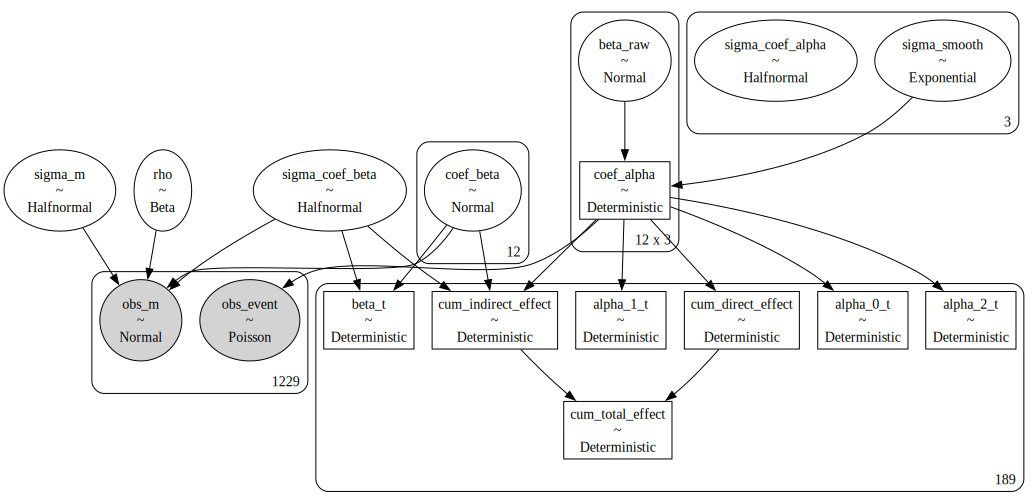

In [7]:
pm.model_to_graphviz(aalen_dpa_model)

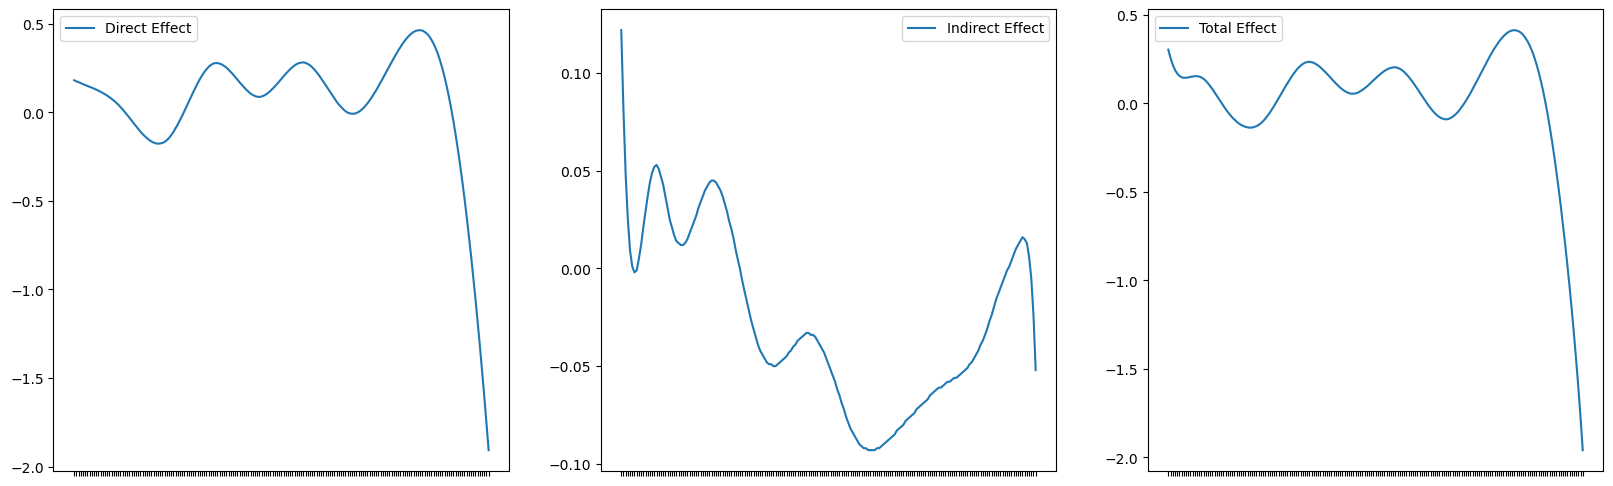

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(az.summary(trace, var_names=['cum_direct_effect'])['mean'], label='Direct Effect')
axs[1].plot(az.summary(trace, var_names=['cum_indirect_effect'])['mean'], label='Indirect Effect')
axs[2].plot(az.summary(trace, var_names=['cum_total_effect'])['mean'], label='Total Effect')
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
axs[2].set_xticklabels([]);
axs[0].legend()
axs[1].legend()
axs[2].legend();


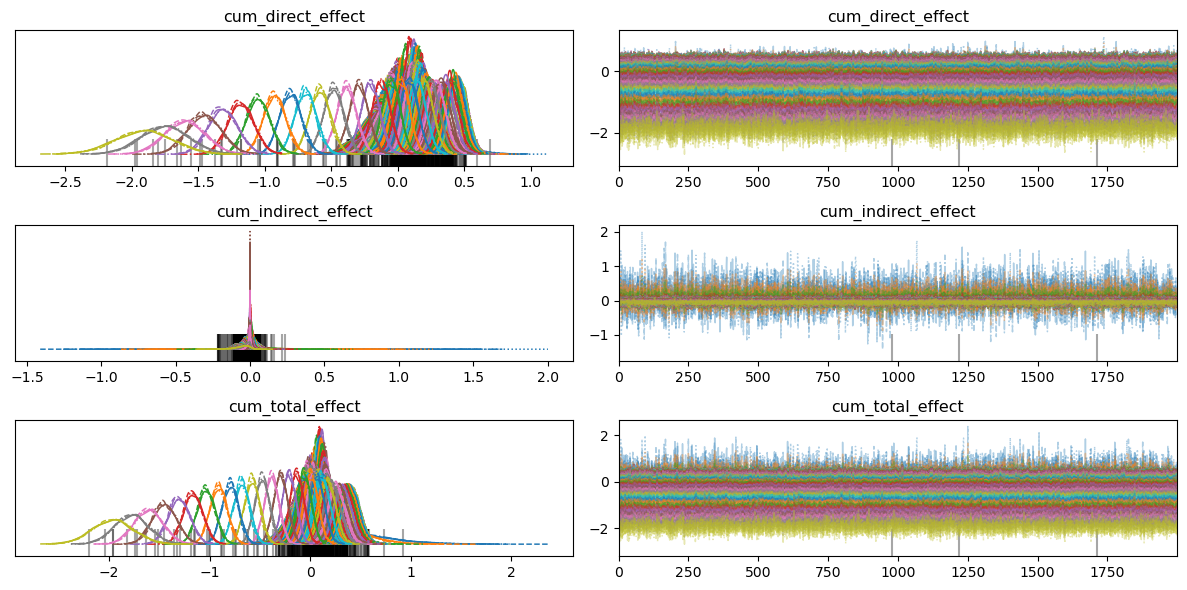

In [9]:
az.plot_trace(trace, var_names=['cum_direct_effect', 'cum_indirect_effect', 'cum_total_effect']);
plt.tight_layout();

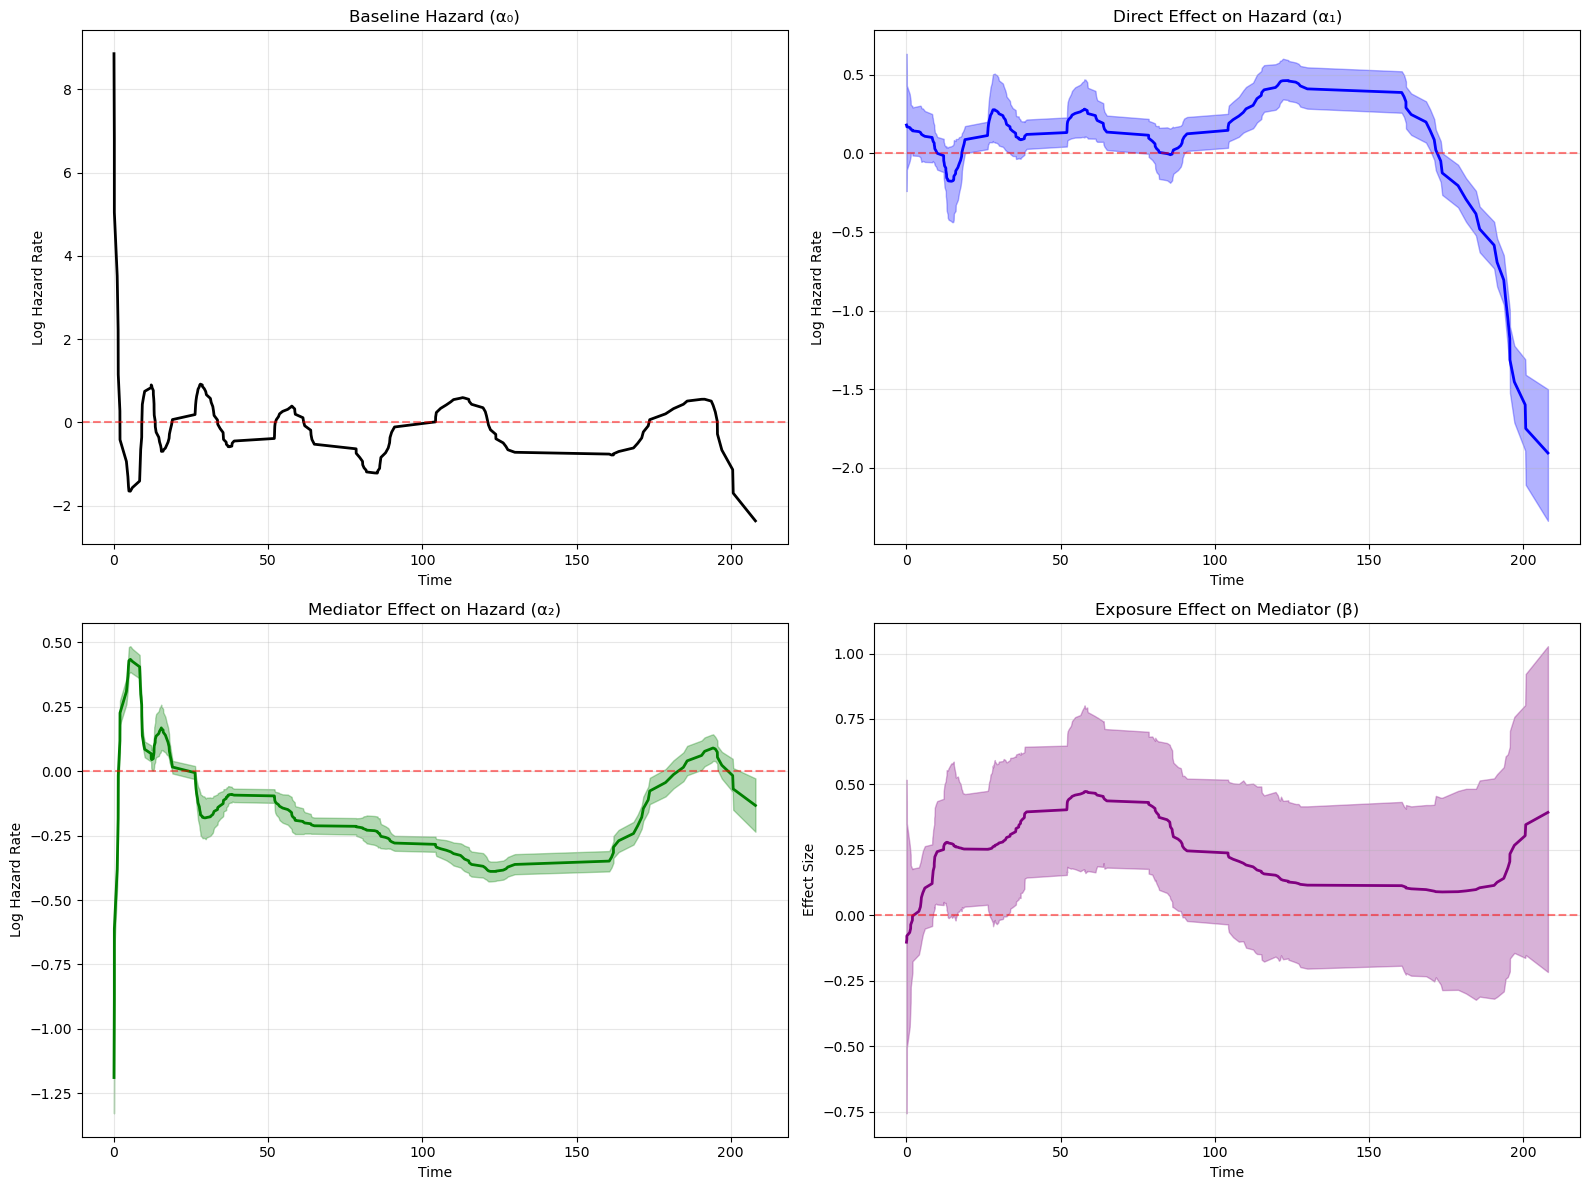

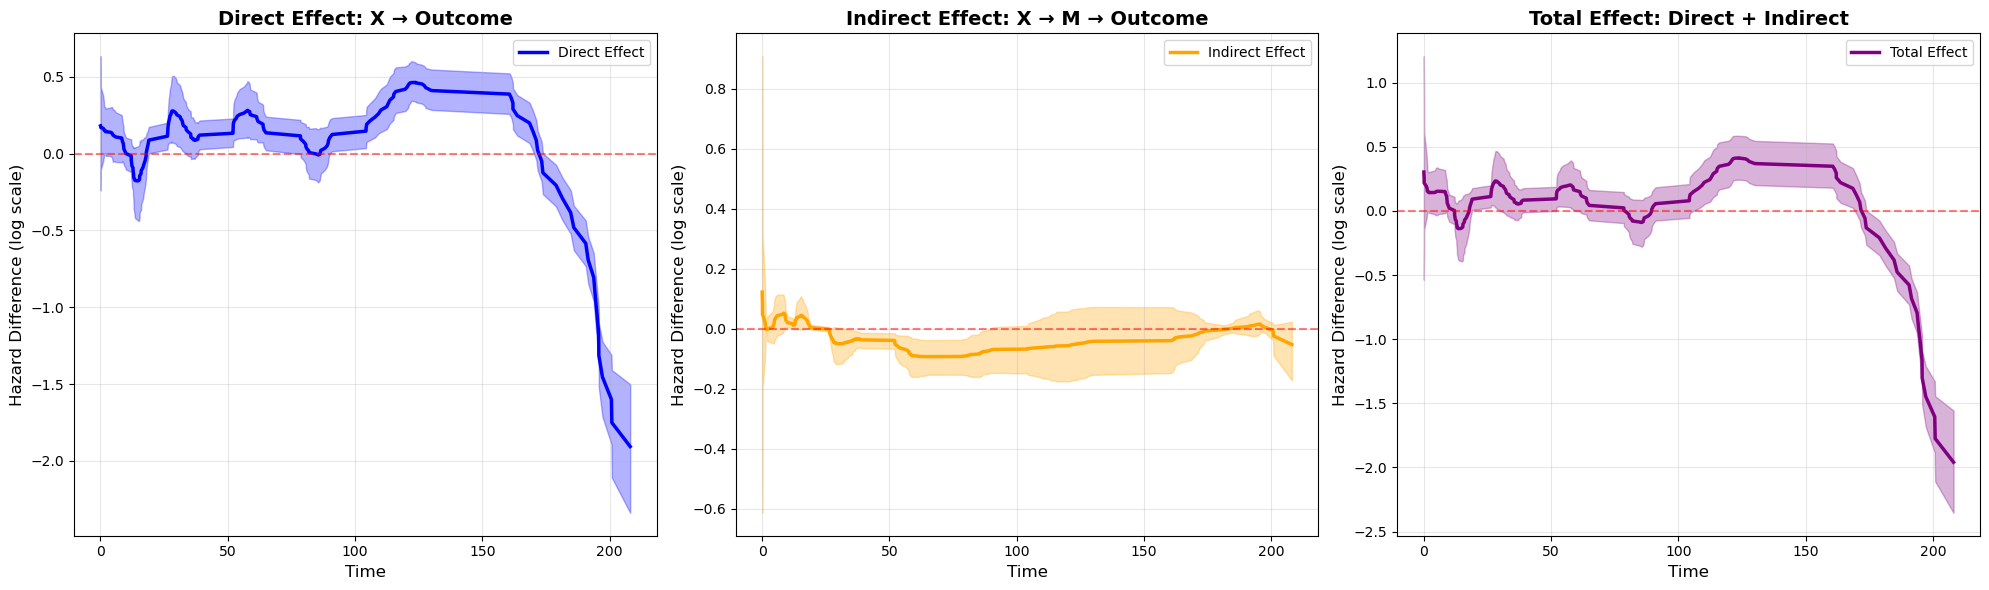


HAZARD RATE EFFECTS SUMMARY

Direct Effect (α₁):
  Mean at t=0: 0.1810
  Mean at t=end: -1.9070
  Overall mean: 0.0489

Mediator Effect on Hazard (α₂):
  Mean at t=0: -1.1890
  Mean at t=end: -0.1330
  Overall mean: -0.1058

Exposure Effect on Mediator (β):
  Mean at t=0: -0.1030
  Mean at t=end: 0.3930
  Overall mean: 0.2532

Indirect Effect (β × α₂):
  Mean at t=0: 0.1225
  Mean at t=end: -0.0523
  Overall mean: -0.0265

Total Hazard Effect:
  Mean at t=0: 0.3035
  Mean at t=end: -1.9593
  Overall mean: 0.0225


In [10]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

# Get time points for plotting
time_points = (bins["start"].values + bins["stop"].values) / 2

# -------------------------------------------------
# Extract hazard components from trace
# -------------------------------------------------

# Baseline hazard over time
baseline_hazard = az.summary(trace, var_names=['alpha_0_t'])['mean'].values

# Direct effect hazard (x -> outcome)
direct_hazard = az.summary(trace, var_names=['alpha_1_t'])['mean'].values

# Mediator effect hazard (M -> outcome, the B path)
mediator_hazard = az.summary(trace, var_names=['alpha_2_t'])['mean'].values

# Mediator model coefficient (x -> M, the A path)
mediator_coef = az.summary(trace, var_names=['beta_t'])['mean'].values

# -------------------------------------------------
# Compute hazard rates for different exposure levels
# -------------------------------------------------

# For a person with x=1 (exposed) vs x=0 (unexposed)
# Assuming mediator at its mean (0 for centered data)

# Hazard for unexposed (x=0, m=0)
hazard_unexposed = baseline_hazard

# Hazard for exposed (x=1, m=0) - direct effect only initially
hazard_exposed_direct = baseline_hazard + direct_hazard

# For visualization of the causal paths:
# Direct hazard contribution from exposure
hazard_direct_contrib = direct_hazard

# Indirect hazard contribution (through mediator)
# This is the effect of exposure on mediator * effect of mediator on hazard
hazard_indirect_contrib = mediator_coef * mediator_hazard

# Total hazard difference between exposed and unexposed
hazard_total_effect = direct_hazard + mediator_coef * mediator_hazard

# -------------------------------------------------
# Plot hazard view
# -------------------------------------------------

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Baseline hazard
axs[0, 0].plot(time_points, baseline_hazard, linewidth=2, color='black')
axs[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Log Hazard Rate')
axs[0, 0].set_title('Baseline Hazard (α₀)')
axs[0, 0].grid(True, alpha=0.3)

# 2. Direct hazard effect
axs[0, 1].plot(time_points, direct_hazard, linewidth=2, color='blue')
hdi_de = az.summary(trace, var_names=['alpha_1_t'], hdi_prob=0.95)
axs[0, 1].fill_between(
    time_points,
    hdi_de['hdi_2.5%'],
    hdi_de['hdi_97.5%'],
    alpha=0.3,
    color='blue'
)
axs[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Log Hazard Rate')
axs[0, 1].set_title('Direct Effect on Hazard (α₁)')
axs[0, 1].grid(True, alpha=0.3)

# 3. Mediator effect on hazard (B path)
axs[1, 0].plot(time_points, mediator_hazard, linewidth=2, color='green')
hdi_me = az.summary(trace, var_names=['alpha_2_t'], hdi_prob=0.95)
axs[1, 0].fill_between(
    time_points,
    hdi_me['hdi_2.5%'],
    hdi_me['hdi_97.5%'],
    alpha=0.3,
    color='green'
)
axs[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Log Hazard Rate')
axs[1, 0].set_title('Mediator Effect on Hazard (α₂)')
axs[1, 0].grid(True, alpha=0.3)

# 4. Exposure effect on mediator (A path)
axs[1, 1].plot(time_points, mediator_coef, linewidth=2, color='purple')
hdi_beta = az.summary(trace, var_names=['beta_t'], hdi_prob=0.95)
axs[1, 1].fill_between(
    time_points,
    hdi_beta['hdi_2.5%'],
    hdi_beta['hdi_97.5%'],
    alpha=0.3,
    color='purple'
)
axs[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Effect Size')
axs[1, 1].set_title('Exposure Effect on Mediator (β)')
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Plot hazard differences (exposure effect decomposition)
# -------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Direct hazard effect
axs[0].plot(time_points, hazard_direct_contrib, linewidth=2.5, color='blue', label='Direct Effect')
axs[0].fill_between(
    time_points,
    hdi_de['hdi_2.5%'],
    hdi_de['hdi_97.5%'],
    alpha=0.3,
    color='blue'
)
axs[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axs[0].set_xlabel('Time', fontsize=12)
axs[0].set_ylabel('Hazard Difference (log scale)', fontsize=12)
axs[0].set_title('Direct Effect: X → Outcome', fontsize=14, fontweight='bold')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Indirect hazard effect
axs[1].plot(time_points, hazard_indirect_contrib, linewidth=2.5, color='orange', label='Indirect Effect')
# Compute HDI for indirect effect manually from posterior samples
indirect_samples = trace.posterior['beta_t'].values * trace.posterior['alpha_2_t'].values
indirect_hdi_lower = np.percentile(indirect_samples, 2.5, axis=(0, 1))
indirect_hdi_upper = np.percentile(indirect_samples, 97.5, axis=(0, 1))
axs[1].fill_between(
    time_points,
    indirect_hdi_lower,
    indirect_hdi_upper,
    alpha=0.3,
    color='orange'
)
axs[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axs[1].set_xlabel('Time', fontsize=12)
axs[1].set_ylabel('Hazard Difference (log scale)', fontsize=12)
axs[1].set_title('Indirect Effect: X → M → Outcome', fontsize=14, fontweight='bold')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Total hazard effect
axs[2].plot(time_points, hazard_total_effect, linewidth=2.5, color='purple', label='Total Effect')
# Compute HDI for total effect
total_samples = (trace.posterior['alpha_1_t'].values + 
                 trace.posterior['beta_t'].values * trace.posterior['alpha_2_t'].values)
total_hdi_lower = np.percentile(total_samples, 2.5, axis=(0, 1))
total_hdi_upper = np.percentile(total_samples, 97.5, axis=(0, 1))
axs[2].fill_between(
    time_points,
    total_hdi_lower,
    total_hdi_upper,
    alpha=0.3,
    color='purple'
)
axs[2].axhline(0, color='red', linestyle='--', alpha=0.5)
axs[2].set_xlabel('Time', fontsize=12)
axs[2].set_ylabel('Hazard Difference (log scale)', fontsize=12)
axs[2].set_title('Total Effect: Direct + Indirect', fontsize=14, fontweight='bold')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Print summary statistics
# -------------------------------------------------

print("\n" + "="*60)
print("HAZARD RATE EFFECTS SUMMARY")
print("="*60)

print("\nDirect Effect (α₁):")
print(f"  Mean at t=0: {direct_hazard[0]:.4f}")
print(f"  Mean at t=end: {direct_hazard[-1]:.4f}")
print(f"  Overall mean: {np.mean(direct_hazard):.4f}")

print("\nMediator Effect on Hazard (α₂):")
print(f"  Mean at t=0: {mediator_hazard[0]:.4f}")
print(f"  Mean at t=end: {mediator_hazard[-1]:.4f}")
print(f"  Overall mean: {np.mean(mediator_hazard):.4f}")

print("\nExposure Effect on Mediator (β):")
print(f"  Mean at t=0: {mediator_coef[0]:.4f}")
print(f"  Mean at t=end: {mediator_coef[-1]:.4f}")
print(f"  Overall mean: {np.mean(mediator_coef):.4f}")

print("\nIndirect Effect (β × α₂):")
print(f"  Mean at t=0: {hazard_indirect_contrib[0]:.4f}")
print(f"  Mean at t=end: {hazard_indirect_contrib[-1]:.4f}")
print(f"  Overall mean: {np.mean(hazard_indirect_contrib):.4f}")

print("\nTotal Hazard Effect:")
print(f"  Mean at t=0: {hazard_total_effect[0]:.4f}")
print(f"  Mean at t=end: {hazard_total_effect[-1]:.4f}")
print(f"  Overall mean: {np.mean(hazard_total_effect):.4f}")
print("="*60)

In [24]:
n_knots = 12
basis = create_bspline_basis(n_bins, n_knots=n_knots, degree=3)
n_basis = basis.shape[1]


with pm.Model() as aalen_dpa_model:

    # -------------------------------------------------
    # 1. B-spline coefficients for HAZARD model
    # -------------------------------------------------
    # Prior on spline coefficients
    # Smaller sigma = less wiggliness
    # Random Walk 1 (RW1) Prior for coefficients
    # This is the Bayesian version of the smoothing penalty in R's 'mgcv' or 'timereg'
    sigma_smooth = pm.Exponential("sigma_smooth", [10, 0.1, 0.1], shape=3)
    beta_raw = pm.Normal("beta_raw", 0, 1, shape=(n_basis, 3))

    # Cumulative sum makes it a Random Walk
    # This ensures coefficients evolve smoothly over time
    coef_alpha = pm.Deterministic("coef_alpha", pt.cumsum(beta_raw * sigma_smooth, axis=0))

    # Construct smooth time-varying functions
    alpha_0_t = pt.dot(basis, coef_alpha[:, 0])
    alpha_1_t = pt.dot(basis, coef_alpha[:, 1])
    alpha_2_t = pt.dot(basis, coef_alpha[:, 2])
    


    # -------------------------------------------------
    # 2. B-spline coefficients for MEDIATOR model
    # -------------------------------------------------
    sigma_coef_beta = pm.HalfNormal("sigma_coef_beta", 0.3)
    
    coef_beta = pm.Normal(
        "coef_beta",
        0,
        1,
        shape=n_basis
    )
    
    beta_t = pt.dot(basis, coef_beta * sigma_coef_beta)

    # -------------------------------------------------
    # 3. Mediator model (A path: x → M)
    # -------------------------------------------------
    sigma_m = pm.HalfNormal("sigma_m", 1.0)
    
    # Autoregressive component
    rho = pm.Beta("rho", 2, 2)
    
    mu_m = beta_t[b] * x + rho * m_lag

    pm.Normal(
        "obs_m",
        mu=mu_m,
        sigma=sigma_m,
        observed=m,
    )

    # -------------------------------------------------
    # 4. Hazard model (direct + B path)
    # -------------------------------------------------
    # Log-additive hazard
    log_lambda_t = (alpha_0_t[b] 
                    + alpha_1_t[b] * x      # direct effect
                    + alpha_2_t[b] * m      # mediator effect
    )
    
    # Expected number of events
    Lambda = Y * dt * pm.math.log1pexp(log_lambda_t)

    pm.Poisson(
        "obs_event",
        mu=Lambda,
        observed=N
    )

    # -------------------------------------------------
    # 5. Causal path effects
    # -------------------------------------------------
    # Store time-varying coefficients
    pm.Deterministic("alpha_0_t", alpha_0_t)
    pm.Deterministic("alpha_1_t", alpha_1_t)  # direct effect
    pm.Deterministic("alpha_2_t", alpha_2_t)  # B path
    pm.Deterministic("beta_t", beta_t)         # A path
    
    # Cumulative direct effect
    cum_de = pm.Deterministic(
        "cum_direct_effect",
        alpha_1_t
    )

    # Cumulative indirect effect (product of paths)
    cum_ie = pm.Deterministic(
        "cum_indirect_effect",
        beta_t * alpha_2_t
    )

    # Total effect
    cum_te = pm.Deterministic(
        "cum_total_effect",
        cum_de + cum_ie
    )



    # -------------------------------------------------
    # 6. Sample
    # -------------------------------------------------
    trace_additive = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.95,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=42,
        init="adapt_diag"
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_31219/191228159.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_val = az.hdi(post_samples, hdi_prob=0.94) # Returns [time, 2] array
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_31219/191228159.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_val = az.hdi(post_samples, hdi_prob=0.94) # Returns [time, 2] array
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_31219/191228159.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_val = az.hdi(post_samples, hdi_prob=0.94) # Returns [time, 2] array


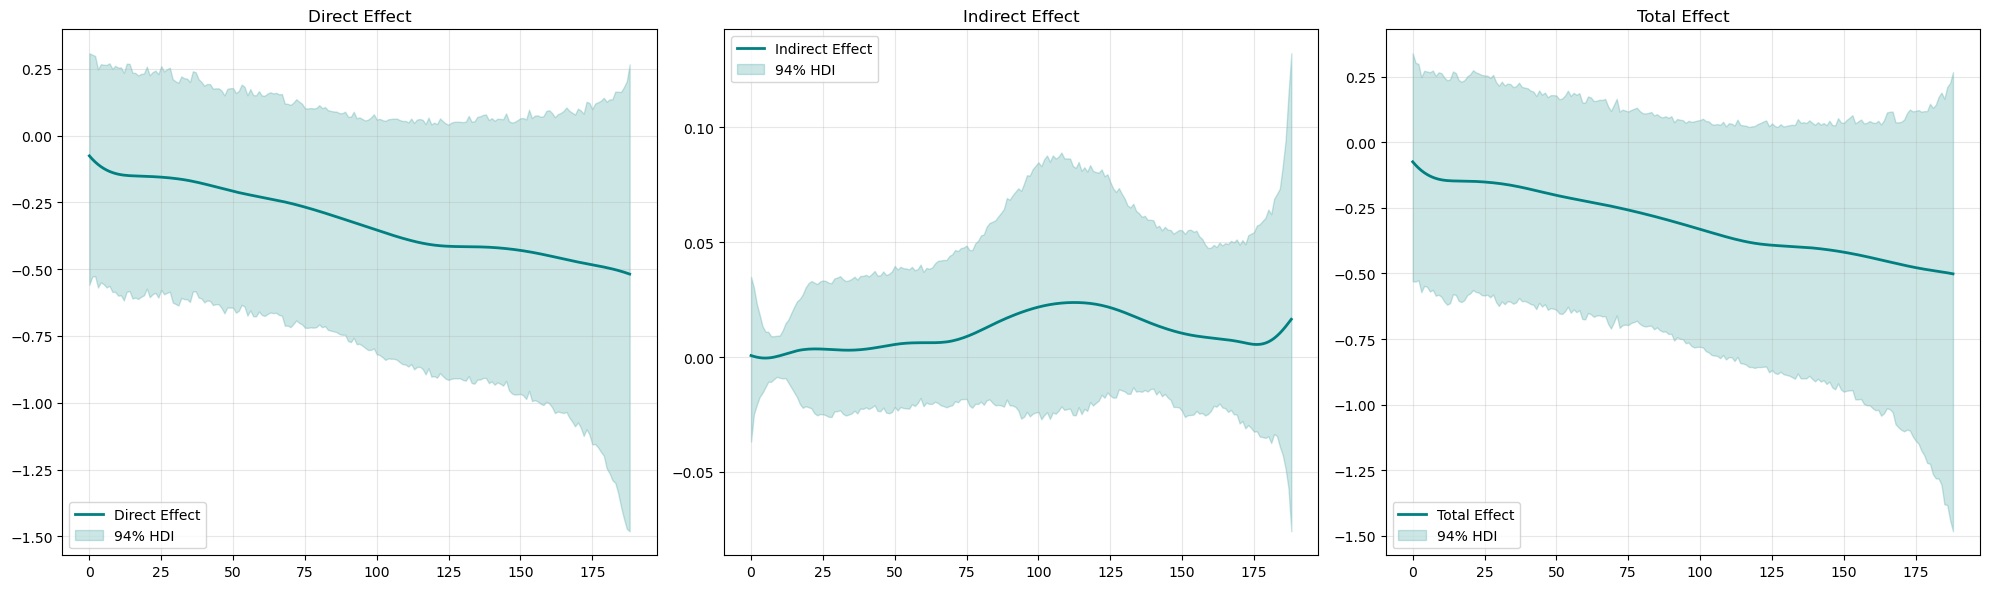

In [25]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Define the variables we want to plot
vars_to_plot = ['cum_direct_effect', 'cum_indirect_effect', 'cum_total_effect']
labels = ['Direct Effect', 'Indirect Effect', 'Total Effect']

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, var in enumerate(vars_to_plot):
    # 1. Extract the posterior samples for this variable
    # Shape will be (chain * draw, time)
    post_samples = az.extract(trace_additive, var_names=[var]).values.T
    
    # 2. Calculate the mean and the 94% HDI across the chains/draws
    mean_val = post_samples.mean(axis=0)
    hdi_val = az.hdi(post_samples, hdi_prob=0.94) # Returns [time, 2] array
    
    # 3. Plot the Mean line
    x_axis = np.arange(len(mean_val))
    axs[i].plot(x_axis, mean_val, label=labels[i], color='teal', lw=2)
    
    # 4. Plot the Shaded HDI region
    axs[i].fill_between(x_axis, hdi_val[:, 0], hdi_val[:, 1], color='teal', alpha=0.2, label='94% HDI')
    
    # Formatting
    axs[i].set_title(labels[i])
    axs[i].legend()
    axs[i].grid(alpha=0.3)
    # If you have a time vector (e.g., days), replace x_axis with your time values

plt.tight_layout()
plt.show()